In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import torch
import time
from tqdm import tqdm
from scipy import linalg
from sklearn.covariance import graphical_lasso, empirical_covariance, shrunk_covariance, GraphicalLassoCV
from sklearn.datasets import make_sparse_spd_matrix
from scipy.spatial.distance import squareform
from sklearn.metrics import average_precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
from gglasso.solver.single_admm_solver import ADMM_SGL
from gglasso.helper.model_selection import single_grid_search
import matplotlib as mpl
import utils_mcf

In [2]:
import rpy2.robjects.packages as rpackages
import anndata2ri

anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
def structure_error(true, pred, thresholding=False, eps=1e-2, no_diagonal=False):
    """
    + + + Code taken from https://github.com/fdtomasi/regain + + +
    
    Error in structure between a precision matrix and predicted.

    Parameters
    ----------
    true: array-like
        True matrix. In grpahical inference, if an entry is different from 0
        it is consider as an edge (inverse covariance).

    pred: array-like, shape=(d,d)
        Predicted matrix. In graphical inference, if an entry is different
        from 0 it is consider as an edge (inverse covariance).

    thresholding: bool, default False,
       Apply a threshold (with eps) to the `pred` matrix.

    eps : float, default = 1e-2
        Apply a threshold (with eps) to the `pred` matrix.

    """
    # avoid inplace modifications
    true = true.copy()
    pred = pred.copy()
    if true.ndim > 2:
        y_true = np.array(flatten([squareform(x, checks=None) for x in true]))
        y_pred = np.array(flatten([squareform(x, checks=None) for x in pred]))
    else:
        y_true = squareform(true, checks=None)
        y_pred = squareform(pred, checks=None)

    average_precision = average_precision_score(y_true > 0, y_pred)
    mcc = matthews_corrcoef(y_true > 0, y_pred > 0)

    if thresholding:
        pred[np.abs(pred) < eps] = 0
    tn_to_remove = 0
    if no_diagonal:
        if true.ndim > 2:
            true = np.array([t - np.diag(np.diag(t)) for t in true])
            pred = np.array([t - np.diag(np.diag(t)) for t in pred])
            tn_to_remove = np.prod(true.shape[:2])
        else:
            true -= np.diag(np.diag(true))
            pred -= np.diag(np.diag(pred))
            tn_to_remove = true.shape[0]
    true[true != 0] = 1
    pred[pred != 0] = 2
    res = true + pred
    # from collections import Counter
    # c = Counter(res.flat)
    # tn, fn, fp, tp = c[0], c[1], c[2], c[3]
    TN = np.count_nonzero((res == 0).astype(float)) - tn_to_remove
    FN = np.count_nonzero((res == 1).astype(float))
    FP = np.count_nonzero((res == 2).astype(float))
    TP = np.count_nonzero((res == 3).astype(float))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN)
    miss_rate = FN / (TP + FN) or 1 - recall
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    accuracy = (TP + TN) / true.size
    prevalence = (TP + FN) / true.size

    fall_out = FP / (FP + TN) if (FP + TN) > 0 else 1
    specificity = TN / (FP + TN) if (FP + TN) > 0 else 1.0 - fall_out

    balanced_accuracy = 0.5 * (recall + specificity)
    false_discovery_rate = FP / (TP + FP) if TP + FP > 0 else 1 - precision
    false_omission_rate = FN / (FN + TN) if FN + TN > 0 else 0
    negative_predicted_value = (
        TN / (FN + TN) if FN + TN > 0 else 1 - false_omission_rate
    )

    positive_likelihood_ratio = recall / fall_out if fall_out > 0 else 0
    negative_likelihood_ratio = miss_rate / specificity if specificity > 0 else 0
    diagnostic_odds_ratio = (
        positive_likelihood_ratio / negative_likelihood_ratio
        if negative_likelihood_ratio > 0
        else 0
    )

    dictionary = dict(
        tp=TP,
        tn=TN,
        fp=FP,
        fn=FN,
        precision=precision,
        recall=recall,
        f1=f1,
        accuracy=accuracy,
        false_omission_rate=false_omission_rate,
        fdr=false_discovery_rate,
        npv=negative_predicted_value,
        prevalence=prevalence,
        miss_rate=miss_rate,
        fall_out=fall_out,
        specificity=specificity,
        plr=positive_likelihood_ratio,
        nlr=negative_likelihood_ratio,
        dor=diagnostic_odds_ratio,
        balanced_accuracy=balanced_accuracy,
        average_precision=average_precision,
        mcc=mcc,
    )
    return dictionary


In [4]:
d = 30 # number of features
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # to generate 10 different ground truth precision matrices
n_samples = [10, 15, 20, 25, 30, 35, 40, 45 ,50]
p_values =  [0.1, 0.25, 0.5, 0.75, 1]
penalties = ['atan', 'selo', 'exp', 'log', 'sica', 'scad', 'mcp', 'adapt', 'lasso']
# some of the above algorithms (penalties) struggle in very low sample regimes,
# so we consider the minimal working number of samples for each method separately
left_outs = dict(zip(penalties, [0, 0, 2, 0, 0, 3, 4, 0, 0])) 

# generate 10 sparse precision matrices of dimendion d x d 
W_list, X_list = [], []
for seed in seeds:
    np.random.seed(seed)
    W = make_sparse_spd_matrix(d, alpha=0.9, random_state=2)
    cov = sp.linalg.inv(W)
    distr = sp.stats.multivariate_normal(mean=np.zeros(d), cov=cov)
    X = distr.rvs(100_000)
    W_list.append(W)
    X_list.append(X)

### Conditional Matrix Flows

In [19]:
# sample precision matrices through the proposed Conditional Matrix Flows
# here we load the trained models (which can be obtained by running 'main.py')
lamb_min_exp, lamb_max_exp = 0, 2
p_min, p_max = .1, 1.5
T0, Tn = 5, 1
epochs = 5001

cmf = []
for i_X, (X, seed) in enumerate(zip(X_list, seeds)):
    print('='*30, ' ', i_X, ' ', '='*30)
    flow_n_samples =[]
    for n in n_samples:
        print(n)
        X_ = X[:n]
        X_ /= X_.std(0)
        S = np.cov(X_, rowvar=False)
        S_torch = torch.from_numpy(S).float().cuda()
        file_name = f'd{d}_n{n}_e{epochs}_pmin{p_min}_pmax{p_max}_lmin{lamb_min_exp}_lmax{lamb_max_exp}_seed{seed}'
        flow_state_dict = torch.load(f"./models_boxplots/cmf_{file_name}"+f"_T1.000")
        flow = utils_mcf.build_positive_definite_vector(d, context_features=32, n_layers=3)
        flow.load_state_dict(flow_state_dict)
        flow.eval()

        f = open(f"./models_boxplots/cmf_{file_name}.txt", "r") 
        alpha = float(f.read()) * n / 2
        log_alpha = np.log10(alpha) 

        p = torch.tensor(1.).cuda()
        flow_p_samples = []
        for p_value in p_values:
            flow_samples_, _, _, _, _, _, _, lambda_sorted = utils_mcf.sample_W_fixed_p(flow, S_torch, p=p*p_value, n=n, T=Tn, context_size=1, sample_size=5, lambda_min_exp=log_alpha, lambda_max_exp=log_alpha)
            flow_samples_ = flow_samples_.reshape(-1, d, d)
            flow_p_samples.append(flow_samples_)
        flow_n_samples.append(flow_p_samples)
    cmf.append(flow_n_samples)
np.save("cmf.npy", cmf)
del flow

==============================   0   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 139.45it/s]


15


100%|██████████| 200/200 [00:01<00:00, 132.86it/s]


20


100%|██████████| 200/200 [00:01<00:00, 136.90it/s]


25


100%|██████████| 200/200 [00:01<00:00, 138.67it/s]


30


100%|██████████| 200/200 [00:01<00:00, 137.52it/s]


35


100%|██████████| 200/200 [00:01<00:00, 132.96it/s]


40


100%|██████████| 200/200 [00:01<00:00, 131.75it/s]


45


100%|██████████| 200/200 [00:01<00:00, 130.46it/s]


50


100%|██████████| 200/200 [00:01<00:00, 140.02it/s]


==============================   1   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 143.51it/s]


15


100%|██████████| 200/200 [00:01<00:00, 147.95it/s]


20


100%|██████████| 200/200 [00:01<00:00, 146.55it/s]


25


100%|██████████| 200/200 [00:01<00:00, 144.47it/s]


30


100%|██████████| 200/200 [00:01<00:00, 143.32it/s]


35


100%|██████████| 200/200 [00:01<00:00, 143.72it/s]


40


100%|██████████| 200/200 [00:01<00:00, 139.56it/s]


45


100%|██████████| 200/200 [00:01<00:00, 138.58it/s]


50


100%|██████████| 200/200 [00:01<00:00, 144.64it/s]


==============================   2   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 137.76it/s]


15


100%|██████████| 200/200 [00:01<00:00, 145.18it/s]


20


100%|██████████| 200/200 [00:01<00:00, 142.28it/s]


25


100%|██████████| 200/200 [00:01<00:00, 140.09it/s]


30


100%|██████████| 200/200 [00:01<00:00, 145.95it/s]


35


100%|██████████| 200/200 [00:01<00:00, 138.97it/s]


40


100%|██████████| 200/200 [00:01<00:00, 145.24it/s]


45


100%|██████████| 200/200 [00:01<00:00, 144.32it/s]


50


100%|██████████| 200/200 [00:01<00:00, 141.93it/s]


==============================   3   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 138.58it/s]


15


100%|██████████| 200/200 [00:01<00:00, 141.38it/s]


20


100%|██████████| 200/200 [00:01<00:00, 145.09it/s]


25


100%|██████████| 200/200 [00:01<00:00, 145.26it/s]


30


100%|██████████| 200/200 [00:01<00:00, 144.55it/s]


35


100%|██████████| 200/200 [00:01<00:00, 138.95it/s]


40


100%|██████████| 200/200 [00:01<00:00, 143.87it/s]


45


100%|██████████| 200/200 [00:01<00:00, 140.31it/s]


50


100%|██████████| 200/200 [00:01<00:00, 139.55it/s]


==============================   4   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 140.86it/s]


15


100%|██████████| 200/200 [00:01<00:00, 144.35it/s]


20


100%|██████████| 200/200 [00:01<00:00, 146.69it/s]


25


100%|██████████| 200/200 [00:01<00:00, 146.08it/s]


30


100%|██████████| 200/200 [00:01<00:00, 142.54it/s]


35


100%|██████████| 200/200 [00:01<00:00, 145.17it/s]


40


100%|██████████| 200/200 [00:01<00:00, 140.28it/s]


45


100%|██████████| 200/200 [00:01<00:00, 137.36it/s]


50


100%|██████████| 200/200 [00:01<00:00, 142.70it/s]


==============================   5   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 135.80it/s]


15


100%|██████████| 200/200 [00:01<00:00, 139.92it/s]


20


100%|██████████| 200/200 [00:01<00:00, 145.37it/s]


25


100%|██████████| 200/200 [00:01<00:00, 141.74it/s]


30


100%|██████████| 200/200 [00:01<00:00, 145.96it/s]


35


100%|██████████| 200/200 [00:01<00:00, 142.35it/s]


40


100%|██████████| 200/200 [00:01<00:00, 135.17it/s]


45


100%|██████████| 200/200 [00:01<00:00, 136.75it/s]


50


100%|██████████| 200/200 [00:01<00:00, 139.82it/s]


==============================   6   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 136.15it/s]


15


100%|██████████| 200/200 [00:01<00:00, 144.91it/s]


20


100%|██████████| 200/200 [00:01<00:00, 147.14it/s]


25


100%|██████████| 200/200 [00:01<00:00, 136.35it/s]


30


100%|██████████| 200/200 [00:01<00:00, 142.20it/s]


35


100%|██████████| 200/200 [00:01<00:00, 141.24it/s]


40


100%|██████████| 200/200 [00:01<00:00, 140.37it/s]


45


100%|██████████| 200/200 [00:01<00:00, 141.57it/s]


50


100%|██████████| 200/200 [00:01<00:00, 138.15it/s]


==============================   7   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 138.51it/s]


15


100%|██████████| 200/200 [00:01<00:00, 144.04it/s]


20


100%|██████████| 200/200 [00:01<00:00, 141.68it/s]


25


100%|██████████| 200/200 [00:01<00:00, 141.13it/s]


30


100%|██████████| 200/200 [00:01<00:00, 143.45it/s]


35


100%|██████████| 200/200 [00:01<00:00, 146.38it/s]


40


100%|██████████| 200/200 [00:01<00:00, 138.75it/s]


45


100%|██████████| 200/200 [00:01<00:00, 143.61it/s]


50


100%|██████████| 200/200 [00:01<00:00, 147.72it/s]


==============================   8   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 140.24it/s]


15


100%|██████████| 200/200 [00:01<00:00, 136.23it/s]


20


100%|██████████| 200/200 [00:01<00:00, 136.20it/s]


25


100%|██████████| 200/200 [00:01<00:00, 143.93it/s]


30


100%|██████████| 200/200 [00:01<00:00, 141.36it/s]


35


100%|██████████| 200/200 [00:01<00:00, 137.00it/s]


40


100%|██████████| 200/200 [00:01<00:00, 143.51it/s]


45


100%|██████████| 200/200 [00:01<00:00, 137.27it/s]


50


100%|██████████| 200/200 [00:01<00:00, 139.69it/s]


==============================   9   ==============================
10


100%|██████████| 200/200 [00:01<00:00, 143.30it/s]


15


100%|██████████| 200/200 [00:01<00:00, 141.32it/s]


20


100%|██████████| 200/200 [00:01<00:00, 141.01it/s]


25


100%|██████████| 200/200 [00:01<00:00, 146.56it/s]


30


100%|██████████| 200/200 [00:01<00:00, 137.69it/s]


35


100%|██████████| 200/200 [00:01<00:00, 143.12it/s]


40


100%|██████████| 200/200 [00:01<00:00, 142.67it/s]


45


100%|██████████| 200/200 [00:01<00:00, 140.55it/s]


50


100%|██████████| 200/200 [00:01<00:00, 138.68it/s]


### Bayesian Graphical Lasso

In [ ]:
# sample precision matrices with the Bayesian Graphical Lasso approach by Wang (2012)
BayesianGLasso = rpackages.importr('BayesianGLasso')

ones = np.ones((1000, d, d))
bayes_glasso_samples = []
start_time = time.time()
for n in n_samples:
    print('+'*40, ' ', n, ' ', '+'*40)
    precisions = []
    for X in X_list:
        X_ = X[:n]
        X_ /= X_.std(0)
        %R -i X_ -o BayesGLasso BayesGLasso <- blockGLasso(X=X_, iterations=4000, burnIn=1000, lambdaPriora=1, lambdaPriorb=.1)
        BayesGlasso_prec = [value for i, (key, value) in enumerate(BayesGLasso['Omegas'].items()) if i+1>1000 and (i+1)%4==0]
        precisions.append(np.array(BayesGlasso_prec))
        print("--- %s seconds ---" % (time.time() - start_time))
    np.save(f"bayes_glasso_samples_{n}.npy", np.array(precisions, dtype=object))
    bayes_glasso_samples.append(precisions)
bayes_glasso_samples = np.array(bayes_glasso_samples, dtype=object)
np.save("bayes_glasso_samples.npy", bayes_glasso_samples)

### Frequentist approach: GMMs with Nonconvex Regularization

Precision matrix reconstruction through two classes of penalties

- l0 approximations:  
    - Atan ("atan") by Wang and Zhu (2016) 
    - Seamless L0 ("selo") by Dicker et al. (2013)
    - Exponential ("exp") by Wang et al. (2018)
    - Log ("log") by Mazumder et al. (2011)
    - SICA ("sica") by Lv and Fan (2009)


- additional penalties(smooth interpolation between l0 and l1):
    - SCAD ("scad") by Fan and Li (2001)
    - MC+ ("mcp") by Zhang (2010)
    - Adaptive lasso ("adapt") by Zou (2006)

In [ ]:
# for more details see the R package 'GGMncv' 
GGmncv = rpackages.importr('GGMncv')
penalties = ['atan', 'selo', 'exp', 'log', 'sica', 'scad', 'mcp', 'adapt', 'lasso']
ggmncv = {}
left_outs = dict(zip(penalties, [0,0,2,0,0,3,4,0,0]))
for penalty in penalties:
    print('='*30, ' ', penalty, ' ', '='*30)
    samples = []
    for n in n_samples[left_outs[penalty]:]:
        print('+'*20, ' ', n, ' ', '+'*20)
        precisions = []    
        for X in X_list:
            X_ = X[:n]
            X_ /= X_.std(0)
            S = np.corrcoef(X_, rowvar=False)
            %R -i S -i n -i d -i penalty -i X_ -o fit fit <- ggmncv(S, n=n, progress = FALSE, penalty=penalty, initial=ledoit_wolf, Y=X_)
            precisions.append(fit['Theta'])
        samples.append(precisions)
    ggmncv[penalty] = np.arrays(samples)
np.save("ggmncv.npy", ggmncv)

### Results comparison

In [5]:
#can choose from a variety of scores: e.g. 'f1', 'accuracy', 'precision' etc.
score = 'f1'

In [6]:
# credibility intervals
conf_bayes = 0.9
conf_flow = 0.9
glasso_scores = []

settings = dict(thresholding=False, eps=1e-2, no_diagonal=False)

print('computing scores for Conditional Matrix Flow...')
cmf = np.load('cmf.npy', allow_pickle=True)
cmf_scores = []
for i_p in range(len(p_values)):
    p_scores = []
    for i_n in range(len(n_samples)):
        n_scores = []
        for i_x, W in enumerate(W_list[:4]):
            n = n_samples[i_n]
            samples = cmf[i_x][i_n][i_p]
            qleft = np.quantile(samples, 0.5 - conf_flow*0.5, 0)
            qright = np.quantile(samples, 0.5 + conf_flow*0.5, 0)
            signif_edge = qleft * qright > 0
            signed_signif = np.sign(qleft) * signif_edge
            error = structure_error(W, signed_signif, **settings)[score]
            n_scores.append(error)
        p_scores.append(n_scores)
    cmf_scores.append(p_scores)
cmf_scores = np.array(cmf_scores)

print('computing scores for Bayesian Graphical Lasso...')
bayes_glasso_samples = np.load('bayes_glasso_samples.npy', allow_pickle=True)
bayes_glasso_scores = []
for i_n in range(len(n_samples[1::2])):
    n = n_samples[i_n]
    error = []
    for i_W, W in enumerate(W_list):
        samples = bayes_glasso_samples[i_n][i_W]
        qleft = np.quantile(samples, 0.5 - conf_bayes*0.5, 0)
        qright = np.quantile(samples, 0.5 + conf_bayes*0.5, 0)
        signif_edge = qleft * qright > 0
        signed_signif = np.sign(qleft) * signif_edge
        error_ = structure_error(W, signed_signif, **settings)[score]
        error.append(error_)
    bayes_glasso_scores.append(error)
bayes_glasso_scores = np.array(bayes_glasso_scores)
    
print('computing scores for GGMncv...')
ggmncv = np.load('ggmncv.npy', allow_pickle=True)[()]
ggmncv_scores = {}
for penalty in penalties:
    n_scores = []
    for i_n in range(len(n_samples[left_outs[penalty]:])):
        n = n_samples[i_n]
        error = [ structure_error(W, ggmncv[penalty][i_n][i_W], **settings)[score] for i_W, W in enumerate(W_list)]
        n_scores.append(error)
    ggmncv_scores[penalty] = np.array(n_scores)

computing scores for Conditional Matrix Flow...
computing scores for Bayesian Graphical Lasso...
computing scores for GGMncv...


In [7]:
# convert to dataframe to use sns.boxplots
df_cmf_dict = {}
for i_p, p_value in enumerate(p_values):
    df_cmf = pd.DataFrame(cmf_scores[i_p].T, columns=n_samples).assign(model=f"CMF ($p$={p_value})")
    df_cmf_dict[p_value] = df_cmf

df_bayes_glasso = pd.DataFrame(bayes_glasso_scores.T, columns = n_samples[1::2]).assign(model='BGL')

df_ggmncv_dict = {}
for penalty in penalties:
    df_ggmncv =pd.DataFrame(ggmncv_scores[penalty].T, columns = n_samples[left_outs[penalty]:]).assign(model=penalty)
    df_ggmncv_dict[penalty] = df_ggmncv

#### Sanity check: Conditional Matrix Flow for p = 1 vs Bayesian Graphical Lasso

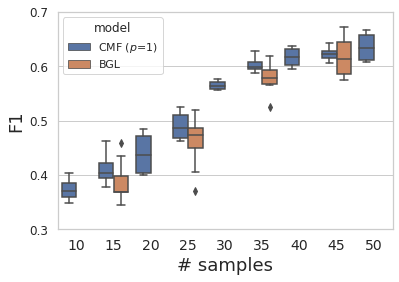

In [19]:
# sns.set(style="whitegrid", font_scale=1.5)
sns.set_theme(style="whitegrid")
cdf = pd.concat([ df_cmf_dict[p_values[4]], df_bayes_glasso])
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name=score)
fig, ax = plt.subplots()
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
sns.boxplot(x="# samples", y=score, hue="model", data=mdf)  # RUN PLOT
plt.xticks(fontsize=14)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=12)
plt.xlabel('# samples', fontsize=18)
plt.ylabel('F1', fontsize=18)
plt.savefig(f"box_plot_{score}_flow_lasso.pdf", dpi=200,  bbox_inches='tight')
plt.show()

#### Conditional Matrix Flow vs frequentist GGMs with l0 approximation penalty

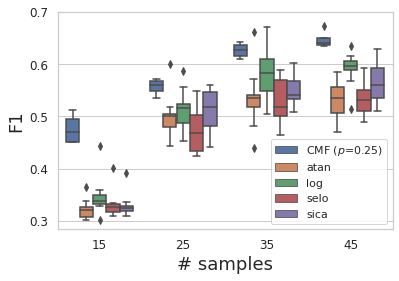

In [20]:
penalties = ['atan', 'selo', 'exp', 'log', 'sica', 'scad', 'mcp', 'adapt', 'lasso']
cdf = pd.concat([df_cmf_dict[p_values[1]], df_ggmncv_dict['atan'], df_ggmncv_dict['log'], df_ggmncv_dict['selo'], 
                 df_ggmncv_dict['sica']])#,  df_ggmncv_dict['exp']])
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name=score)
plt.figure()
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
g = sns.boxplot(x="# samples", y=score, hue="model", data=mdf_subset)  # RUN PLOT
plt.xticks(fontsize=12)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=12)
plt.xlabel('# samples', fontsize=18)
plt.ylabel('F1', fontsize=18)
g.legend_.set_title(None)
plt.savefig(f"box_plot_{score}_flow_l0ncv.pdf", dpi=200,  bbox_inches='tight')
plt.show()

#### Conditional Matrix Flow (with p<1) vs Bayesian Graphical Lasso

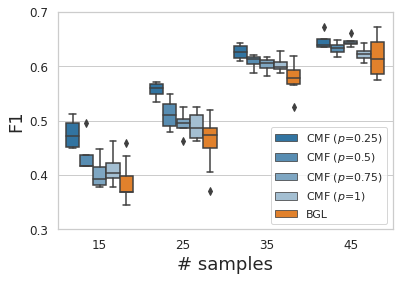

In [21]:
palette_tab10 = sns.color_palette("tab10", 10)
palette_blue = list(sns.light_palette(palette_tab10[0], n_colors=6))[::-1][:4]
palette_salmon = list(sns.light_palette(palette_tab10[1], n_colors=6))[::-1][:1]
palette = palette_blue + palette_salmon

cdf = pd.concat([df_cmf_dict[p_values[1]], df_cmf_dict[p_values[2]], 
                 df_cmf_dict[p_values[3]], df_cmf_dict[p_values[4]], df_bayes_glasso])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name=score)
plt.figure()
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
g = sns.boxplot(x="# samples", y=score, hue="model", data=mdf_subset, palette=palette)  # RUN PLOT
plt.xticks(fontsize=12)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=12)
plt.xlabel('# samples', fontsize=18)
plt.ylabel('F1', fontsize=18)
g.legend_.set_title(None)
plt.savefig(f"box_plot_{score}_flow_bayes_glasso.pdf",  bbox_inches='tight')
plt.show()

#### Conditional Matrix Flow (with p<1) vs SCAD, MC+ and Adaptive lasso (as a function of $\gamma$)

In [41]:
# select gamma for each method. We start from the minimal working gamma in each setting
gamma_dict = dict(scad= [3.5,4,5,10,100], 
                  mcp= [2,3,4,10,100],#,3.5,10,100]
                  adapt= [0.1,0.2,0.3,0.5,1])#,0.3,0.5,1])

In [42]:
GGmncv = rpackages.importr('GGMncv')
ggmncv_gamma = {}
left_outs = dict(zip(penalties[-4:-1], [3,4,0]))
for penalty in penalties[-4:-1]:
    print('='*30, ' ', penalty, ' ', '='*30)
    gamma_list = {}
    for gamma in gamma_dict[penalty]:
        print('-'*20, ' ', gamma, ' ', '-'*20)
        sample_list = []
        for n in n_samples[left_outs[penalty]:]:
            print('+'*20, ' ', n, ' ', '+'*20)
            prec_list = []    
            for X in X_list:
                X_ = X[:n]
                X_ /= X_.std(0)
                S = np.corrcoef(X_, rowvar=False)
                %R -i S -i n -i d -i penalty -i X_ -i gamma -o fit fit <- ggmncv(S, n=n, progress = FALSE, penalty=penalty, initial=ledoit_wolf, Y=X_, gamma=gamma)
                prec_list.append(fit['Theta'])
            sample_list.append(prec_list)
        gamma_list[gamma] = np.array(sample_list)
    ggmncv_gamma[penalty] = gamma_list
np.save("ggmncv_gamma.npy", ggmncv_gamma)

R[write to console]: 

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


KeyboardInterrupt



In [43]:
print('computing scores for GGMncv gamma...')
ggmncv_gamma = np.load('ggmncv_gamma.npy', allow_pickle=True)[()]
ggmncv_gamma_score = {}
for penalty in penalties[-4:-1]:
    gamma_score = {}
    for gamma in gamma_dict[penalty]:
        n_scores = []
        for i_n in range(len(n_samples[left_outs[penalty]:])):
            n = n_samples[i_n]
            error = [ structure_error(W, ggmncv_gamma[penalty][gamma][i_n][i_W], 
                                      **settings)[score] for i_W, W in enumerate(W_list)]
            n_scores.append(error)
        gamma_score[gamma] = np.array(n_scores)
    ggmncv_gamma_score[penalty] = gamma_score

computing scores for GGMncv gamma...


#### Conditional Matrix Flow (with p<1) vs adaptive Lasso

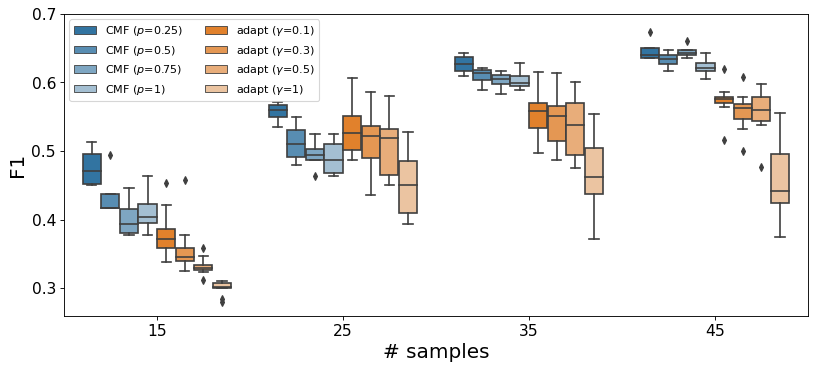

In [90]:
penalty = 'adapt'

palette_blue = list(sns.light_palette(palette_tab10[0], n_colors=6))[::-1][:4]
palette_salmon = list(sns.light_palette(palette_tab10[1], n_colors=6))[::-1][:4]
palette = palette_blue + palette_salmon

df_ggmncv_gamma_dict = {}
for gamma in gamma_dict[penalty]:
    df_ggmncv = pd.DataFrame(ggmncv_gamma_score[penalty][gamma].T, 
                            columns = n_samples[left_outs[penalty]:]).assign(model=f"{penalty} ($\gamma$={gamma})")
    df_ggmncv_gamma_dict[gamma] = df_ggmncv

cdf = pd.concat([df_cmf_dict[p_values[1]], df_cmf_dict[p_values[2]], 
                 df_cmf_dict[p_values[3]], df_cmf_dict[p_values[4]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][0]], df_ggmncv_gamma_dict[gamma_dict[penalty][2]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][3]], df_ggmncv_gamma_dict[gamma_dict[penalty][4]]])
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name=score)
plt.figure()
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
ax = sns.boxplot(x="# samples", y=score, hue="model", data=mdf_subset, palette=palette)
plt.xticks(fontsize=14)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=14)
plt.xlabel('# samples', fontsize=18)
plt.ylabel('F1', fontsize=18)
plt.legend(ncol=2, loc='lower center')
plt.legend(ncol=2, loc='upper left')
plt.savefig(f"box_plot_{score}_flow_{penalty}_.pdf", dpi=200,  bbox_inches='tight')
plt.show()

#### Conditional Matrix Flow (with p<1) vs SCAD

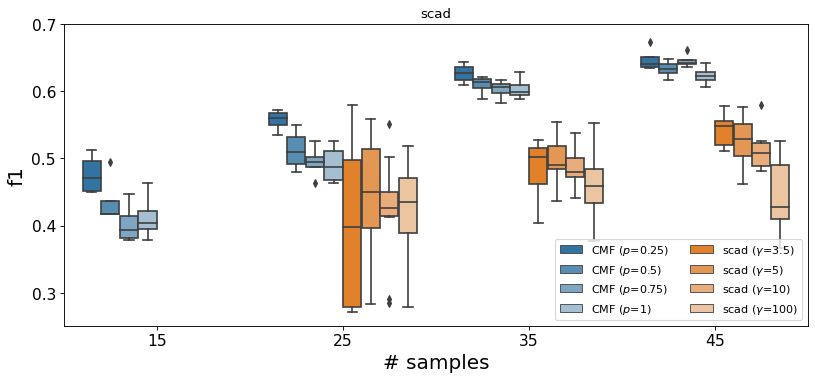

In [79]:
penalty = 'scad'

palette_blue = list(sns.light_palette(palette_tab10[0], n_colors=6))[::-1][:4]
palette_salmon = list(sns.light_palette(palette_tab10[1], n_colors=6))[::-1][:4]
palette = palette_blue + palette_salmon

df_ggmncv_gamma_dict = {}
for gamma in gamma_dict[penalty]:
    df_ggmncv = pd.DataFrame(ggmncv_gamma_score[penalty][gamma].T, 
                            columns = n_samples[left_outs[penalty]:]).assign(model=f"{penalty} ($\gamma$={gamma})")
    df_ggmncv_gamma_dict[gamma] = df_ggmncv

cdf = pd.concat([df_cmf_dict[p_values[1]], df_cmf_dict[p_values[2]], 
                 df_cmf_dict[p_values[3]], df_cmf_dict[p_values[4]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][0]], df_ggmncv_gamma_dict[gamma_dict[penalty][2]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][3]], df_ggmncv_gamma_dict[gamma_dict[penalty][4]]])
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name='f1')
plt.figure()
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
ax = sns.boxplot(x="# samples", y=score, hue="model", data=mdf_subset, palette=palette)
plt.title(penalty)
plt.xticks(fontsize=14)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=14)
plt.xlabel('# samples', fontsize=18)
plt.ylabel(score, fontsize=18)
plt.legend(ncol=2, loc='lower right')
plt.savefig(f"box_plot_{score}_flow_{penalty}_.pdf", dpi=200,  bbox_inches='tight')
plt.show()

#### Conditional Matrix Flow (with p<1) vs MC+

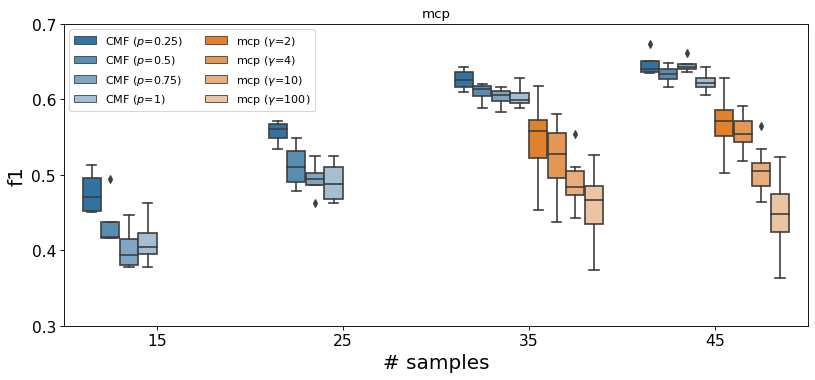

In [74]:
penalty = 'mcp'

palette_blue = list(sns.light_palette(palette_tab10[0], n_colors=6))[::-1][:4]
palette_salmon = list(sns.light_palette(palette_tab10[1], n_colors=6))[::-1][:4]
palette = palette_blue + palette_salmon

df_ggmncv_gamma_dict = {}
for gamma in gamma_dict[penalty]:
    df_ggmncv = pd.DataFrame(ggmncv_gamma_score[penalty][gamma].T, 
                            columns = n_samples[left_outs[penalty]:]).assign(model=f"{penalty} ($\gamma$={gamma})")
    df_ggmncv_gamma_dict[gamma] = df_ggmncv

cdf = pd.concat([df_cmf_dict[p_values[1]], df_cmf_dict[p_values[2]], 
                 df_cmf_dict[p_values[3]], df_cmf_dict[p_values[4]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][0]], df_ggmncv_gamma_dict[gamma_dict[penalty][2]], 
                 df_ggmncv_gamma_dict[gamma_dict[penalty][3]], df_ggmncv_gamma_dict[gamma_dict[penalty][4]]])
mdf = pd.melt(cdf, id_vars=['model'], var_name='# samples', value_name=score)
plt.figure()
mdf_subset = mdf.loc[mdf['# samples'].isin([15,25,35,45])]
ax = sns.boxplot(x="# samples", y=score, hue="model", data=mdf_subset, palette=palette)
plt.title(penalty)
plt.xticks(fontsize=14)
plt.yticks([0.3,0.4,0.5,0.6,0.7], fontsize=14)
plt.xlabel('# samples', fontsize=18)
plt.ylabel(score, fontsize=18)
plt.legend(ncol=2, loc='upper left')
plt.savefig(f"box_plot_{score}_flow_{penalty}_.pdf", dpi=200,  bbox_inches='tight')
plt.show()